<a href="https://colab.research.google.com/github/paul028/myJupyterNotebook/blob/master/CIFAR10_3L_CNN_TPUv9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image CLassifier trained using CIFAR10 dataset using 3-layer Convolutional Neural Network**
1. This model was trained Using TPU from google Colab
2. Implements Data Augmentation
3. Implements Regularization Technique 
  *  Dropout
  *  Kernel Regularizer
  * Batch Normalization


1. Import all the Necessary Libraries

In [0]:
#!pip install hyperopt
#!pip install hyperas
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.misc import toimage
#from hyperas.distributions import uniform, choice
#from hyperopt import Trials, STATUS_OK, tpe
#from hyperas import optim
import numpy as np
import os
import tensorflow as tf

Using TensorFlow backend.


Create a Training Plot Class for Live monitoring of Training

In [0]:

class TrainingPlot(tf.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

2. Call the Address of the TPU

In [0]:
# This address identifies the TPU we'll use when configuring TensorFlow.
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

3. Prepare the Dataset

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
num_classes =  len(np.unique(y_train))
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)


170500096/170498071 [==============================] - 3s 0us/step


4. Dataset Augmentation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  del sys.path[0]


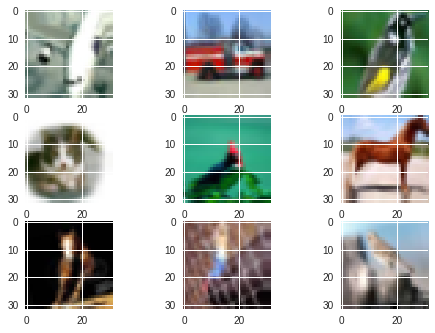

In [0]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=128):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(toimage(X_batch[i].reshape(32, 32, 3)))
    # show the plot
    plt.show()
    break

5. Initialize the Parameters

In [0]:
batch_size = 64
weight_decay = 1e-4

6. Prepare the Model

In [0]:
model = Sequential()
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()
opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #categorical_crossentropy

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
activation_1 (Activat

7. Define a Function for Changing Learning Rate

In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 40:
        lrate = 0.0005
    if epoch > 60:
        lrate = 0.0003
    if epoch > 80:
        lrate = 0.0001
    if epoch > 100:
        lrate = 0.00003  
    return lrate

8. Convert the Model to TPU

In [0]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
model,
strategy=tf.contrib.tpu.TPUDistributionStrategy(
    tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.46.184.154:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 2960389256129426957)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6693017812628370481)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5636204095199021911)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1

9. Train the Network

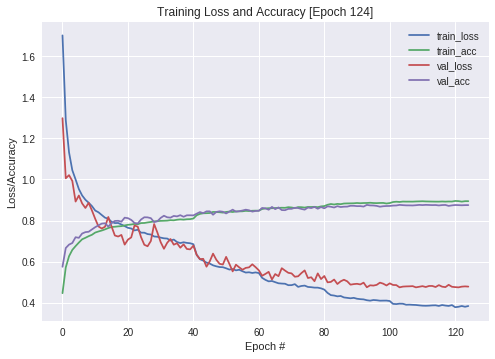

782/782 [==============================] - 26s 34ms/step - loss: 0.3840 - acc: 0.8944 - val_loss: 0.4784 - val_acc: 0.8752


In [0]:
tpu_model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule),plot_losses])

10. Testing

In [0]:

scores = tpu_model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print("\nTest result: %.3f loss: %.3f" % (scores[1]*100,scores[0]))


INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(16, 32, 32, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(16, 10), dtype=tf.float32, name='dense_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f7f6c4b2c18> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 1.8383779525756836 secs
10000/10000 [==============================] - 4s 363us/sample - loss: 0.4781 - acc: 0.8745

Test result: 87.450 loss: 0.478


Best Training Accuracy: 89.44%
<br>Best Testing Accuracy: 87.45%